submitted by Tarang Ranpara

## Part 1 - training CBOW and Skipgram models

In [ ]:
# load library gensim (contains word2vec implementation)
import gensim

# ignore some warnings (probably caused by gensim version)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores

from tqdm import tqdm 

# importing needed libs 
import os
import re
import nltk
import pickle
import scipy
import numpy as np
from bs4 import BeautifulSoup as bs
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# downloading needed data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir data
! cp 'drive/MyDrive/IRLAB/A3/FIRE_Dataset_EN_2010.rar' './data/FIRE_Dataset_EN_2010.rar' > nul
! unrar x data/FIRE_Dataset_EN_2010.rar data > nul 
! tar -xvf  './data/FIRE_Dataset_EN_2010/English-Data.tgz' -C './data/FIRE_Dataset_EN_2010/' > nul

In [ ]:
class DataReader:
  def read_and_process(self, data_dir):

    # stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    # wordnet lemmatizer
    stemmer = nltk.stem.PorterStemmer()

    file_names = []
    text_tokens = []

    i = 0
    # iterating over 2004, 2005, 2006, 2007 etc dirs
    for dir in tqdm(os.listdir(data_dir)):
      dir_name = os.path.join(data_dir,dir)

      # iterating over bengal, business, foreign etc dirs
      for sub_dir in os.listdir(dir_name):
        sub_dir_name = os.path.join(dir_name,sub_dir)
        data_files = os.listdir(sub_dir_name)

        for f in data_files:
          f_name = os.path.join(sub_dir_name,f)
          
          with open(f_name,'r') as fobj:
            content = fobj.read()

          soup = bs(content, "lxml")

          # find text tag
          temp_text_data = soup.find('text').text

          # converting text to lower case
          temp_text_data = temp_text_data.lower()

          # removing numbers and special chars
          temp_text_data = re.sub(r'[^\w\s]', '', temp_text_data)
          temp_text_data = re.sub(r'\d+', '', temp_text_data)

          # tokens
          tokens = nltk.word_tokenize(temp_text_data)

          # removing stopwords
          tokens = [token for token in tokens if token not in stopwords]

          # lemmatizing
          tokens = list(map(stemmer.stem,tokens))

          # removing empty files
          if len(tokens) > 0:
            text_tokens.append(tokens)
            file_names.append(f)
            
            if i%5000==0:
              print(i, ' - ', f)
            i += 1

    # list of tokens, list of file names
    return text_tokens, file_names

In [ ]:
data_dir = "./data/FIRE_Dataset_EN_2010/TELEGRAPH_UTF8/"

dr = DataReader()
text_tokens, file_names = dr.read_and_process(data_dir)

  0%|          | 0/4 [00:00<?, ?it/s]

0  -  1060907_sports_story_6711669.utf8
5000  -  1060628_sports_story_6410936.utf8
10000  -  1061024_business_story_6909405.utf8
15000  -  1060603_business_story_6305652.utf8
20000  -  1060305_opinion_story_5902346.utf8
25000  -  1061018_foreign_story_6885902.utf8
30000  -  1060829_calcutta_story_6668664.utf8
35000  -  1060404_nation_story_6054704.utf8


 25%|██▌       | 1/4 [05:36<16:50, 336.86s/it]

40000  -  1050118_sports_story_4266489.utf8
45000  -  1051228_sports_story_5653332.utf8
50000  -  1050718_business_story_5003081.utf8
55000  -  1050416_business_story_4621191.utf8
60000  -  1050801_opinion_story_4998218.utf8
65000  -  1050330_foreign_story_4549739.utf8
70000  -  1050729_calcutta_story_5045296.utf8
75000  -  1050111_nation_story_4239192.utf8
80000  -  1051126_nation_story_5524189.utf8


 50%|█████     | 2/4 [11:13<11:12, 336.48s/it]

85000  -  1070703_sports_story_8009081.utf8
90000  -  1070724_business_story_8098035.utf8
95000  -  1070729_bengal_story_8121171.utf8
100000  -  1070730_foreign_story_8123921.utf8
105000  -  1070622_calcutta_story_7954892.utf8
110000  -  1070626_nation_story_7975107.utf8


 75%|███████▌  | 3/4 [15:40<05:04, 304.82s/it]

115000  -  1041101_business_story_3949825.utf8
120000  -  1040902_foreign_story_3707389.utf8
125000  -  1041014_nation_story_3879773.utf8


100%|██████████| 4/4 [17:38<00:00, 264.72s/it]


In [ ]:
for sentence in text_tokens[30:40]:
    print(sentence)

['telegraph', 'calcutta', 'sport', 'citi', 'mohammedan', 'sport', 'defend', 'habibur', 'rahman', 'mondal', 'hospitalis', 'late', 'tuesday', 'owe', 'dehydr', 'habibur', 'collaps', 'soon', 'match', 'eastern', 'railway', 'admit', 'nurs', 'home', 'barasat', 'learnt', 'fast', 'month', 'ramadan', 'condit', 'stabl', 'accord', 'club', 'offici', 'sourav', 'kothari', 'made', 'last', 'four', 'stage', 'west', 'bengal', 'open', 'snooker', 'meet', 'brc', 'tuesday', 'defeat', 'niraj', 'khemka', 'quarter', 'final', 'aditya', 'goenka', 'beat', 'shah', 'baaz', 'khan', 'shyam', 'jagtiani', 'account', 'srivardhan', 'poddar', 'footbal', 'cfl', 'premier', 'divis', 'east', 'bengal', 'vs', 'mohun', 'bagan', 'salt', 'lake', 'stadium', 'pm', 'snooker', 'west', 'bengal', 'state', 'open', 'brc', 'semifin', 'pm']
['telegraph', 'calcutta', 'sport', 'lack', 'commit', 'show', 'french', 'display', 'talk', 'tactic', 'pk', 'banerje', 'mix', 'feel', 'watch', 'franc', 'held', 'south', 'korea', 'sunday', 'night', 'one', 'h

### cbow model

In [ ]:
# CBOW Model 
w2v_model = gensim.models.Word2Vec(min_count=20,
                                   window=5,
                                   size=100,
                                   sample=6e-5, 
                                   alpha=0.03, 
                                   min_alpha=0.0007, 
                                   negative=20,
                                   workers=cores-1,
                                   sg=0
                                   )

In [ ]:
w2v_model.build_vocab(text_tokens, progress_per=10000)
w2v_model.train(text_tokens, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)
w2v_model.init_sims(replace=True)

In [ ]:
# word vectors are stored in model.wv
print("Size of the vocabulary: %d number of unique words have been considered" % len(w2v_model.wv.vocab))

example_word = 'woman'
print("\nWord vector of " + example_word)
print(w2v_model.wv[example_word].size)
print(w2v_model.wv[example_word])
print("\nWords with most similar vector representations to " + example_word)
print(w2v_model.wv.most_similar(example_word))

# similarity directly:
print("\nCosine similarity to other words:")
print(w2v_model.similarity('woman','man'))
print(w2v_model.similarity('woman','tree'))

Size of the vocabulary: 37231 number of unique words have been considered

Word vector of woman
100
[ 6.36353940e-02  1.18012421e-01 -1.51836604e-01 -4.75290604e-03
 -1.91944420e-01  8.68941322e-02  9.28632095e-02  1.00673094e-01
 -1.38693795e-01  8.26979449e-05  2.66762346e-01  1.45558506e-01
 -1.79897055e-01 -2.68514156e-02  6.70778304e-02  8.37405547e-02
  8.59311670e-02 -3.02767120e-02 -1.38722584e-01 -1.97500885e-01
  1.28468797e-01 -4.30447496e-02  6.62310747e-03 -6.72670752e-02
 -9.81159136e-02  5.79101145e-02 -1.43320158e-01  1.28622264e-01
 -7.89580047e-02 -1.11073606e-01  6.01805896e-02 -2.75434226e-01
  1.96634494e-02  2.91445758e-02  3.20910662e-02  3.67841609e-02
  1.90692946e-01 -1.54307857e-01  7.57366344e-02 -5.03922291e-02
  1.04580559e-01 -3.06135826e-02 -5.75922653e-02  9.79838297e-02
  1.88134879e-01 -1.54758440e-02  9.26820859e-02 -6.14467710e-02
 -4.01611477e-02 -3.82382539e-03  6.86802119e-02 -7.86005557e-02
 -4.32714336e-02  1.36524662e-01 -2.58667469e-02 -9.971

In [ ]:
# words most similar to "man"
w2v_model.wv.most_similar("man")

[('woman', 0.7298637628555298),
 ('pretend', 0.6580207347869873),
 ('middleag', 0.6338212490081787),
 ('teenag', 0.6185839176177979),
 ('stranger', 0.6114965081214905),
 ('yearold', 0.6064582467079163),
 ('men', 0.6023073792457581),
 ('terrifi', 0.5963964462280273),
 ('somehow', 0.59483802318573),
 ('forgiv', 0.5899583697319031)]

In [ ]:
# words most similar to "politician"
w2v_model.wv.most_similar("politician")

[('bureaucrat', 0.7337076663970947),
 ('polit', 0.7128171920776367),
 ('corrupt', 0.6702496409416199),
 ('nepot', 0.6700968742370605),
 ('openli', 0.6591141223907471),
 ('petti', 0.6375821828842163),
 ('hypocrisi', 0.6344172358512878),
 ('cynic', 0.6306552886962891),
 ('partisan', 0.6145445108413696),
 ('congressmen', 0.6117047667503357)]

In [ ]:
w2v_model.wv.most_similar(positive=["king", "girl"], negative=["queen"], topn=10)

[('boy', 0.6142615079879761),
 ('parent', 0.5492401123046875),
 ('teenag', 0.5333204865455627),
 ('brothel', 0.49687808752059937),
 ('father', 0.4950751066207886),
 ('prostitut', 0.4866122007369995),
 ('youth', 0.4748697280883789),
 ('guardian', 0.46173906326293945),
 ('kidnapp', 0.45759475231170654),
 ('classmat', 0.4561840295791626)]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


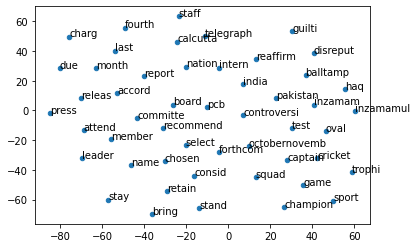

In [ ]:
import numpy as np
labels = []
count = 0
max_count = 50
X = np.zeros(shape=(max_count, len(w2v_model['car'])))

for term in w2v_model.wv.vocab:
    X[count] = w2v_model[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)


# Show the scatter plot
import matplotlib.pyplot as plt
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()

### skipgram model

In [ ]:
# SkipGram Model 
w2v_model = gensim.models.Word2Vec(min_count=20,
                                   window=5,
                                   size=100,
                                   sample=6e-5, 
                                   alpha=0.03, 
                                   min_alpha=0.0007, 
                                   negative=20,
                                   workers=cores-1,
                                   sg=1
                                   )

In [ ]:
w2v_model.build_vocab(text_tokens, progress_per=10000)
w2v_model.train(text_tokens, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)
w2v_model.init_sims(replace=True)

In [ ]:
# word vectors are stored in model.wv
print("Size of the vocabulary: %d number of unique words have been considered" % len(w2v_model.wv.vocab))

example_word = 'woman'
print("\nWord vector of " + example_word)
print(w2v_model.wv[example_word].size)
print(w2v_model.wv[example_word])
print("\nWords with most similar vector representations to " + example_word)
print(w2v_model.wv.most_similar(example_word))

# similarity directly:
print("\nCosine similarity to other words:")
print(w2v_model.similarity('woman','man'))
print(w2v_model.similarity('woman','tree'))

Size of the vocabulary: 37231 number of unique words have been considered

Word vector of woman
100
[ 0.20888568  0.02737415  0.09096011 -0.09068958 -0.03622135  0.02913115
 -0.06685317  0.15616357  0.11949717  0.07687791  0.16022684  0.16081136
  0.07205797  0.02098889 -0.11893652  0.0256019   0.15424688 -0.05425572
  0.05402754  0.14650342  0.17975086 -0.09375731  0.02586257 -0.14226653
  0.02420994  0.00837906  0.1324245  -0.02747981 -0.07025246  0.08474078
 -0.23859608 -0.07812609  0.02534412 -0.00844623 -0.01741578  0.2356396
 -0.00413785 -0.00551944 -0.08818627 -0.00512843  0.08693646 -0.1278764
 -0.05414504 -0.00371923  0.12828027  0.00809663 -0.09504739  0.00199978
 -0.05340042  0.07869313  0.07884455  0.1781668   0.21927612  0.12865216
 -0.07139372 -0.01382894 -0.0261934  -0.12434293 -0.08776408  0.01126127
 -0.0334066   0.06298133 -0.00475473  0.03233583  0.0639558   0.03937637
  0.03405946 -0.15514056 -0.11455347 -0.05197909 -0.10834977 -0.09620244
  0.12970681 -0.14850192  

In [ ]:
w2v_model.wv.most_similar("man")

[('middleag', 0.7591733932495117),
 ('potbelli', 0.7323006391525269),
 ('yearold', 0.7246603965759277),
 ('woman', 0.7239115238189697),
 ('someon', 0.7099756598472595),
 ('welldress', 0.7054553627967834),
 ('father', 0.6931183338165283),
 ('mildmann', 0.6907799243927002),
 ('pretend', 0.6899071931838989),
 ('policeman', 0.6890074014663696)]

In [ ]:
w2v_model.wv.most_similar("politician")

[('bureaucrat', 0.7939152121543884),
 ('polit', 0.7865594625473022),
 ('corrupt', 0.7696572542190552),
 ('nepot', 0.7513159513473511),
 ('powerhungri', 0.7123661041259766),
 ('patronag', 0.7103352546691895),
 ('petti', 0.6953808069229126),
 ('businessmen', 0.6931336522102356),
 ('apparatchik', 0.6877325177192688),
 ('selfseek', 0.6858354210853577)]

In [ ]:
w2v_model.wv.most_similar(positive=["king", "girl"], negative=["queen"], topn=10)
# probably not enough data?

[('boy', 0.5933575630187988),
 ('prostitut', 0.5589313507080078),
 ('teenag', 0.5303976535797119),
 ('child', 0.5263533592224121),
 ('parent', 0.5159709453582764),
 ('pregnant', 0.4966689944267273),
 ('rape', 0.4961240887641907),
 ('sarpanch', 0.4954252243041992),
 ('children', 0.49472835659980774),
 ('tamanna', 0.4940378665924072)]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


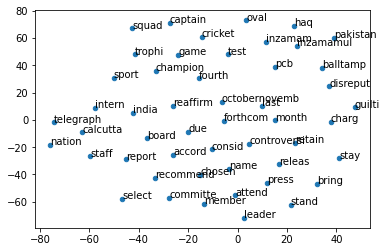

In [ ]:
import numpy as np
labels = []
count = 0
max_count = 50
X = np.zeros(shape=(max_count, len(w2v_model['car'])))

for term in w2v_model.wv.vocab:
    X[count] = w2v_model[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)


# Show the scatter plot
import matplotlib.pyplot as plt
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()

## Part 2 - Training token classification models 

In [ ]:
import nltk 
nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
import gensim.downloader 

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


### preparing data

In [ ]:
positives = list(opinion_lexicon.positive())
negatives = list(opinion_lexicon.negative())

positives = [(tok, 1) for tok in positives ]
negatives = [(tok, 0) for tok in negatives ]

data = positives + negatives

In [ ]:
final_dataset = []
categories = []

for word, category in data:
    try:
        emb = wv_model.wv[word]
        final_dataset.append(emb)
        categories.append(category)
    except:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


### SVC

In [ ]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(final_dataset, categories, test_size=0.25, stratify=categories)

In [ ]:
wv_model = gensim.downloader.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
from sklearn.svm import SVC 

svc = SVC()
svc.fit(x_train, y_train)
print(f'Score: {svc.score(x_test, y_test)}')

Score: 0.8982808022922636


### Feed Forward Neural net for classification  

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.metrics import Precision, Recall 

vector_size = len(x_train[0])
batch_size = 64
epochs = 20 

In [ ]:
def NN(input_size, activation): 
    inputs = Input(shape=(input_size, ))
    x = Dense(64, activation=activation)(inputs)
    x = Dense(32, activation=activation)(x)
    x = Dense(16, activation=activation)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs = inputs, outputs = outputs, name='token_classification')

In [ ]:
model = NN(100, 'relu')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

In [ ]:
H = model.fit(np.array(x_train), np.array(y_train), batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
59/59 [==============================] - 3s 14ms/step - loss: 0.5171 - precision_2: 0.9570 - recall_2: 0.0746 - val_loss: 0.4146 - val_precision_2: 0.9600 - val_recall_2: 0.3934
Epoch 2/20
59/59 [==============================] - 0s 7ms/step - loss: 0.3248 - precision_2: 0.8574 - recall_2: 0.6957 - val_loss: 0.3026 - val_precision_2: 0.8103 - val_recall_2: 0.7705
Epoch 3/20
59/59 [==============================] - 0s 7ms/step - loss: 0.2504 - precision_2: 0.8448 - recall_2: 0.8256 - val_loss: 0.3032 - val_precision_2: 0.8713 - val_recall_2: 0.7213
Epoch 4/20
59/59 [==============================] - 0s 6ms/step - loss: 0.2233 - precision_2: 0.8686 - recall_2: 0.8365 - val_loss: 0.2953 - val_precision_2: 0.8348 - val_recall_2: 0.7869
Epoch 5/20
59/59 [==============================] - 0s 7ms/step - loss: 0.2068 - precision_2: 0.8788 - recall_2: 0.8508 - val_loss: 0.3031 - val_precision_2: 0.8049 - val_recall_2: 0.8115
Epoch 6/20
59/59 [==============================] - 0s 7ms/

In [ ]:
l, p, r = model.evaluate(np.array(x_test), np.array(y_test))

44/44 [==============================] - 0s 5ms/step - loss: 0.5982 - precision_2: 0.8088 - recall_2: 0.8014


In [ ]:
print(f'F1: {2 * p * r/ (p+r)}')

F1: 0.8050458604580735
